In [1]:
from pathlib import Path
import numpy as np
import torch
from torch.distributions import MultivariateNormal
from torchvision.utils import make_grid, save_image
import tqdm
import matplotlib.pyplot as plt

from ex2mcmc.samplers import mala, i_sir, ex2_mcmc
from ex2mcmc.utils.general_utils import CHECKPOINT_DIR, PROJECT_PATH, IMGS_DIR

import sys
sys.path.append(PROJECT_PATH.as_posix())
from experiments.exp_mnist.gan_mnist import GeneratorMNIST, DiscriminatorMNIST

2023-04-17 14:32:41.160447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
gen_mnist = GeneratorMNIST(2).to(device).eval()
discr_mnist = DiscriminatorMNIST().to(device).eval()
gen_mnist.load_state_dict(torch.load(Path(CHECKPOINT_DIR, 'MNIST/vanilla_gan.pth'))[0])
discr_mnist.load_state_dict(torch.load(Path(CHECKPOINT_DIR, 'MNIST/vanilla_gan.pth'))[1])

prior_mnist = torch.distributions.MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))


In [4]:
def get_energy(z):
    return (-discr_mnist(gen_mnist(z)).reshape(z.shape[0]) - prior_mnist.log_prob(z))

def log_target_dens(z, detach=True, batch_size=128):
    """
    returns the value of a target density - mixture of the 3 gaussians 
    """
    res = []
    for i in range(z.shape[0] // batch_size + (1 if z.shape[0] % batch_size else 0)):
        cur_res = -get_energy(z[batch_size * i: batch_size * (i+1)])
        
        if detach:
            cur_res = cur_res.detach()
        
        res.append(cur_res)
    
    return torch.cat(res)


### Put parameters of the target density

In [5]:
seed = 42
torch.manual_seed(42)

lat_size = 2
N_samples = 3
a = 2

x0 = torch.randn(N_samples, lat_size).to(device)

# I-SIR

In [6]:
sigma_isir = 3.0
isir_proposal = MultivariateNormal(
    torch.zeros(lat_size).to(device), 
    (sigma_isir ** 2) * torch.eye(lat_size).to(device))

N_particles = 10
N_steps = 100
np.random.seed(42)

Samples_isir = i_sir(log_target_dens=log_target_dens, x0=x0, N_steps=N_steps, N_part=N_particles, isir_proposal=isir_proposal)

energies_isir = -log_target_dens(Samples_isir.reshape(-1, lat_size)).reshape(N_samples, N_steps + 1).cpu()

100%|██████████| 100/100 [00:07<00:00, 12.58it/s]


100%|██████████| 79/79 [00:26<00:00,  2.98it/s]


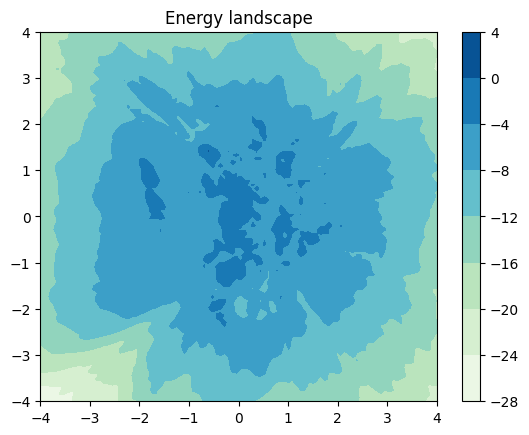

In [7]:
N_pts = 100
xlist = np.linspace(-2*a, 2*a, N_pts)
ylist = np.linspace(-2*a, 2*a, N_pts)
X, Y = np.meshgrid(xlist, ylist)
points = np.zeros((X.shape[0],X.shape[1], 2),dtype=float)
points[:, :, 0] = X
points[:, :, 1] = Y
points = points.reshape(-1, 2)

batch_size = 128
        
dens_vals = []
prop_vals = []
for i in tqdm.tqdm(range(points.shape[0] // batch_size + (1 if points.shape[0] % batch_size else 0))):
    z = torch.FloatTensor(points[i * batch_size: (i + 1) * batch_size]).to(device)
    dens_vals.append(-get_energy(z).detach().cpu().numpy())
    prop_vals.append(isir_proposal.log_prob(z).detach().cpu().numpy())

dens_vals = np.concatenate(dens_vals).reshape(N_pts, N_pts)
prop_vals = np.concatenate(prop_vals).reshape(N_pts, N_pts)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, dens_vals, cmap='GnBu')
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Energy landscape')
plt.show()

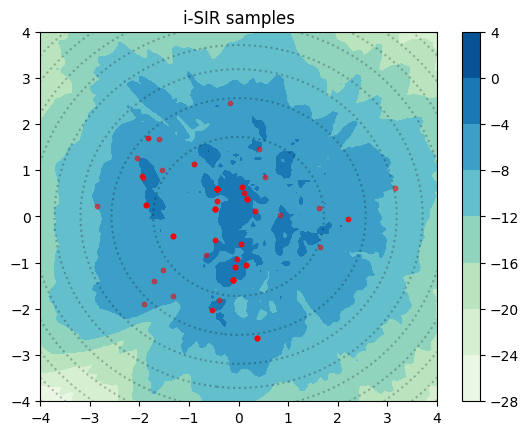

In [8]:
fig, ax = plt.subplots(1,1)

cp = ax.contourf(X, Y, dens_vals, cmap='GnBu')
ax.contour(X, Y, prop_vals, 10, colors='k', linestyles=':', alpha=0.25)
fig.colorbar(cp) # Add a colorbar to a plot
ax.scatter(Samples_isir[0, :, 0], Samples_isir[0, :, 1], s=10, c='r', alpha=0.5)
ax.set_title(r'i-SIR samples')
plt.show()

# MALA 

In [9]:
N_steps = 100

gamma = 2e-2
mala_iters = 3

stats = {'n_accepts': 0}

Samples_mala = mala(log_target_dens=log_target_dens, x0=x0, N_steps=N_steps, gamma=gamma, mala_iters=mala_iters, stats=stats)

energies_mala = -log_target_dens(Samples_mala.reshape(-1, lat_size)).reshape(N_samples, N_steps + 1).cpu()

100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


In [10]:
# fig, ax = plt.subplots(1,1)

# cp = ax.contourf(X, Y, dens_vals, cmap='GnBu')
# fig.colorbar(cp) # Add a colorbar to a plot
# ax.scatter(Samples_mala[0, :, 0], Samples_mala[0, :, 1], s=10, c='r', alpha=0.5)
# ax.set_title('MALA samples')
# plt.show()

In [11]:
print(stats['n_accepts'])

305.0


# Ex2MCMC

In [12]:
N_steps = 100

sigma_isir = 3.0
isir_proposal = MultivariateNormal(
    torch.zeros(lat_size).to(device), 
    (sigma_isir ** 2) * torch.eye(lat_size).to(device))

N_particles = 10

gamma = 2e-2
mala_iters = 3

stats = {'n_accepts': 0}

Samples_ex2 = ex2_mcmc(log_target_dens=log_target_dens, x0=x0, N_steps=N_steps, 
                       N_part=N_particles, isir_proposal=isir_proposal ,
                       gamma=gamma, mala_iters=mala_iters, stats=stats)

energies_ex2 = -log_target_dens(Samples_ex2.reshape(-1, lat_size)).reshape(N_samples, N_steps + 1).cpu()

100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


In [13]:
# fig, ax = plt.subplots(1,1)

# cp = ax.contourf(X, Y, dens_vals, cmap='GnBu')
# fig.colorbar(cp) # Add a colorbar to a plot
# ax.scatter(Samples_ex2[0, :,0], Samples_ex2[0, :,1], s=10, c='r', alpha=0.5)
# ax.set_title(r'Ex$^2$MCMC samples')
# plt.show()

### Plot all 3 pictures together

/var/folders/gk/yv68jbjj32j26cvt7xtkvq2r0000gp/T/ipykernel_49193/3510891274.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xs = torch.tensor(chains, dtype=torch.float)


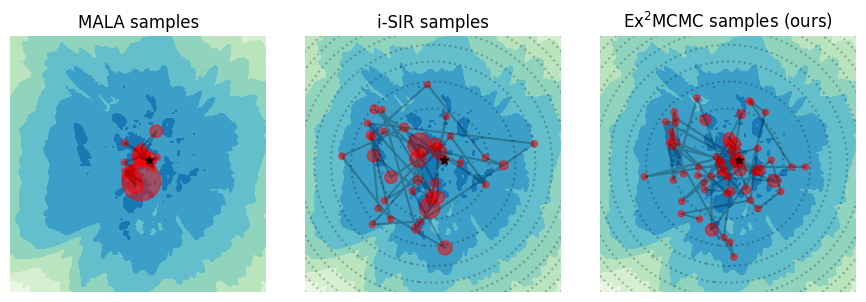

In [14]:
fig, axs = plt.subplots(1 ,3, figsize=(9, 3))
    
chainss = [Samples_mala[0], Samples_isir[0], Samples_ex2[0]]
titles = ['MALA samples', 'i-SIR samples', 'Ex$^2$MCMC samples (ours)']
for idx, (ax, chains, title) in enumerate(zip(axs, chainss, titles)):
    ax.set_title(title)
    ax.contourf(X, Y, dens_vals, cmap='GnBu')
    if idx > 0:
        ax.contour(X, Y, prop_vals, 10, colors='k', linestyles=':', alpha=0.25)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.axis('off')
    ax.set_aspect('equal')
    
    xs = torch.tensor(chains, dtype=torch.float)
    posx, invx, countsx = torch.unique_consecutive(xs[:, 0], return_counts=True, return_inverse=True)
    posy, invy, countsy = torch.unique_consecutive(xs[:, 1], return_counts=True, return_inverse=True)

    ax.plot(xs[:, 0], xs[:, 1], '-', c='k', alpha=0.25)
    ax.scatter(posx, posy, marker='o', c='r', alpha=0.5, s=countsx*20)
    ax.scatter(xs[0,0], xs[0,1],  marker='*', c='k', alpha=0.75, s=40)
    

fig.tight_layout()
# plt.savefig(Path(IMGS_DIR, 'energy_landscape.png'))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


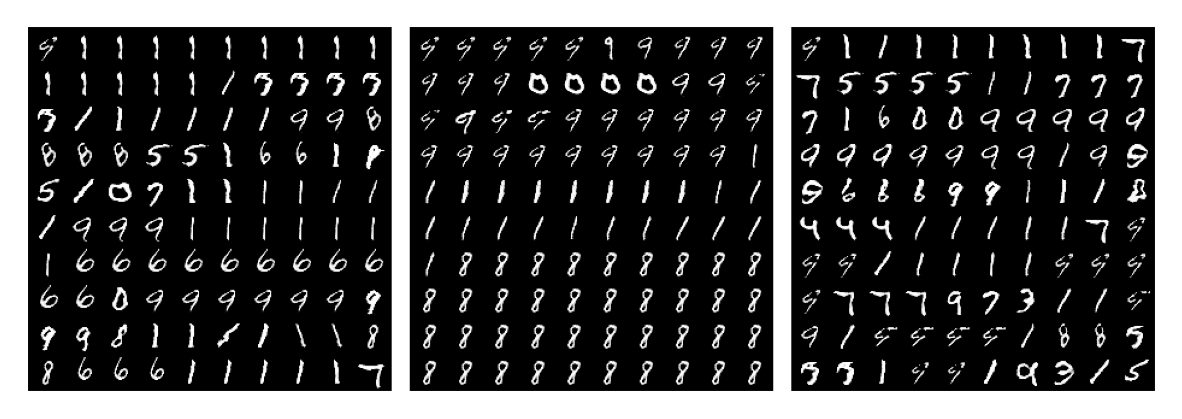

In [15]:
grids = []
for sample in (Samples_isir[0], Samples_mala[0], Samples_ex2[0]):
    sampled_mnist = gen_mnist(torch.FloatTensor(sample[1:, :]))
    grid = make_grid(sampled_mnist, nrow=10)
    grids.append(grid)

grid = make_grid(grids, nrow=3, padding=15, pad_value=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()